In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import time 
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

nhl = pd.read_csv('nhl.csv', encoding= 'latin-1')
nhl.columns

Index(['Rk', 'Player', 'Age', 'Pos', 'Tm', 'GP', 'G', 'A', 'PTS', 'plusminus',
       'PIM', 'PS', 'EV', 'PP', 'SH', 'GW', 'EV.1', 'PP.1', 'SH.1', 'S',
       'S_percent', 'TOI', 'ATOI', 'BLK', 'HIT', 'FOW', 'FOL', 'FO_percent',
       'HART', 'Votes', 'Season'],
      dtype='object')

In [2]:
#renaming columns to be more logical
nhl = nhl.rename(
    {'G' :'total_goals',
    'A' : 'total_assists',
    'PTS' : 'total_points',
    'EV' : 'even_goals',
    'PP': 'pp_goals',
    'SH': 'sh_goals',
    'GW': 'gw_goals',
    'EV.1':'even_assists',
    'PP.1': 'pp_assists',
    'SH.1': 'sh_assists',
    'S': 'shots'} , axis = 1)

#features to keep for data wrangling
wrangling_columns = ['Player', 
                'GP', 
                'PIM', 
                'PS', 
                'even_goals', 
                'pp_goals', 
                'sh_goals', 
                'gw_goals', 
                'even_assists', 
                'pp_assists', 
                'sh_assists', 
                'shots', 
                'TOI', 
                'BLK', 
                'HIT', 
                'FOW', 
                'FOL']

## Features for Clustering
clustering_columns = ['player',
    'pim_gp',
    'even_g_gp',
    'pp_g_gp',
    'sh_g_gp', 
    'gw_g_gp',
    'even_a_gp',
    'pp_a_gp',
    'sh_a_gp',
    'sh_perc',
    'avg_toi',
    'avg_blocks',
    'avg_hits',
    'fow']

nhl_cleaned = nhl[wrangling_columns]

#summing type(x)type(x)up their stands to be cumulative
grouped = nhl_cleaned.groupby('Player').sum().reset_index()

In [3]:
## Run through each player, calculate per game stats, and append to df
cleaned_df = pd.DataFrame(columns = clustering_columns) 
player_list = list(set(grouped['Player']))
for player in player_list:
    player_df = grouped.loc[grouped['Player'] == player].reset_index()
    player = player_df['Player'][0]
    games_played = player_df['GP'][0]
    pim_gp = float(player_df['PIM'][0] / games_played) 
    even_g_gp = float(player_df['even_goals'][0] / games_played)
    pp_g_gp = float(player_df['pp_goals'][0] / games_played)
    sh_g_gp = float(player_df['sh_goals'][0] / games_played)
    gw_g_gp = float(player_df['gw_goals'][0] / games_played)
    total_g = player_df['even_goals'][0] + player_df['pp_goals'][0] + player_df['sh_goals'][0]  + player_df['gw_goals'][0]
    if player_df['shots'][0] == 0:
        sh_perc = 0
    else:
        sh_perc = float(total_g / player_df['shots'][0])

    even_a_gp = float(player_df['even_assists'][0] / games_played)
    pp_a_gp = float(player_df['pp_assists'][0] / games_played) 
    sh_a_gp = float(player_df['sh_assists'][0] / games_played)
    avg_toi = float(player_df['TOI'][0] / games_played)
    avg_blocks = float(player_df['BLK'][0] / games_played) 
    avg_hits = float(player_df['HIT'][0] / games_played)
    total_fo = player_df['FOW'][0] + player_df['FOL'][0]
    if total_fo == 0:
        fow_perc = float(0)
    else:
        fow_perc = float(player_df['FOW'][0] / total_fo)

    cleaned_df = cleaned_df.append({
    'player' : player,
    'pim_gp': pim_gp,
    'even_g_gp' : even_a_gp,
    'pp_g_gp' : pp_g_gp,
    'sh_g_gp' : sh_g_gp, 
    'gw_g_gp' : gw_g_gp,
    'even_a_gp' : even_a_gp,
    'pp_a_gp' : pp_a_gp,
    'sh_a_gp' : sh_a_gp,
    'sh_perc' : sh_perc,
    'avg_toi' : avg_toi,
    'avg_blocks': avg_blocks,
    'avg_hits': avg_hits,
    'fow': fow_perc 
    }, ignore_index = True)


## Visualize data
# sns.pairplot(cleaned_df)
# plt.show()

In [4]:
## Subset player list and drop player
players_index = cleaned_df['player']
cleaned_df = cleaned_df.drop('player', axis = 1)

# Scaling Data
ss = MinMaxScaler()
transformed = ss.fit_transform(cleaned_df)

## Outpitting range of silhouette scores.
for i in range (2,10):
    results = AgglomerativeClustering(n_clusters = i, linkage = 'average').fit(transformed)
    silhouette_avg = silhouette_score(transformed, results.labels_)
    print("For n_clusters =", i, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 2 The average silhouette_score is : 0.574498090335587
For n_clusters = 3 The average silhouette_score is : 0.5310496675140838
For n_clusters = 4 The average silhouette_score is : 0.5159006218478693
For n_clusters = 5 The average silhouette_score is : 0.48350600068864924
For n_clusters = 6 The average silhouette_score is : 0.4440905004135338
For n_clusters = 7 The average silhouette_score is : 0.4107550388041996
For n_clusters = 8 The average silhouette_score is : 0.41020388919130907
For n_clusters = 9 The average silhouette_score is : 0.34071818683658583


In [5]:
clustering_df = ss.fit_transform(cleaned_df)

## Choosing 4 clusters for grouping reasons
clustering = AgglomerativeClustering(n_clusters = 4).fit(clustering_df)
print("The sizes for each cluster are:", Counter(clustering.labels_))

The sizes for each cluster are: Counter({0: 804, 1: 703, 3: 682, 2: 540})


In [6]:
stat_columns = [
    'pim_gp',
    'even_g_gp',
    'pp_g_gp',
    'sh_g_gp', 
    'gw_g_gp',
    'even_a_gp',
    'pp_a_gp',
    'sh_a_gp',
    'sh_perc',
    'avg_toi',
    'avg_blocks',
    'avg_hits',
    'fow']

## Inversing for more readable stats for later on
inversed = ss.inverse_transform(clustering_df)
inversed = pd.DataFrame(inversed, columns = stat_columns)

# addings columns columns for later use
inversed['cluster'] = clustering.labels_
inversed['player'] = players_index

## Scaled DF for t-sne and PCA visuals
df_scaled = pd.DataFrame(clustering_df, columns = stat_columns)    

In [7]:
df_scaled.head()

,pim_gp,even_g_gp,pp_g_gp,sh_g_gp,gw_g_gp,even_a_gp,pp_a_gp,sh_a_gp,sh_perc,avg_toi,avg_blocks,avg_hits,fow
0,0.043829,0.039216,0.000000,0.0,0.00000,0.039216,0.0,0.0,0.041667,0.310052,0.000000,0.000000,0.000000
1,0.549020,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.276063,0.000000,0.333333,0.000000
2,0.000000,0.000000,0.000000,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.288903,0.166667,0.166667,0.000000
3,0.146891,0.042694,0.008403,0.0,0.00759,0.042694,0.0,0.0,0.031477,0.375958,0.077166,0.459836,0.396364
4,0.058824,0.125000,0.000000,0.0,0.00000,0.125000,0.0,0.0,0.250000,0.616327,0.000000,0.000000,0.000000


[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 2729 samples in 0.004s...
[t-SNE] Computed neighbors for 2729 samples in 0.255s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2729
[t-SNE] Computed conditional probabilities for sample 2000 / 2729
[t-SNE] Computed conditional probabilities for sample 2729 / 2729
[t-SNE] Mean sigma: 0.085445
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.444496
[t-SNE] KL divergence after 700 iterations: 0.851335
Time elapsed: 19.086398601531982 seconds
Explained variation per principal component: [0.42265298 0.25460674 0.12532443]


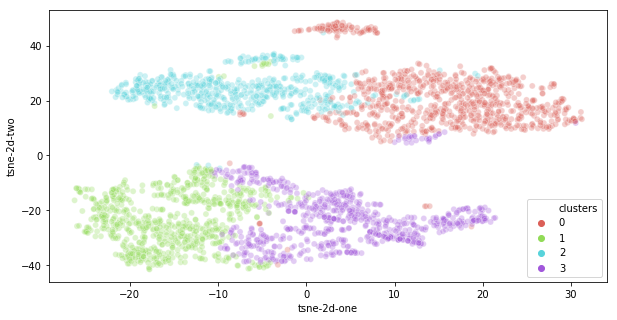

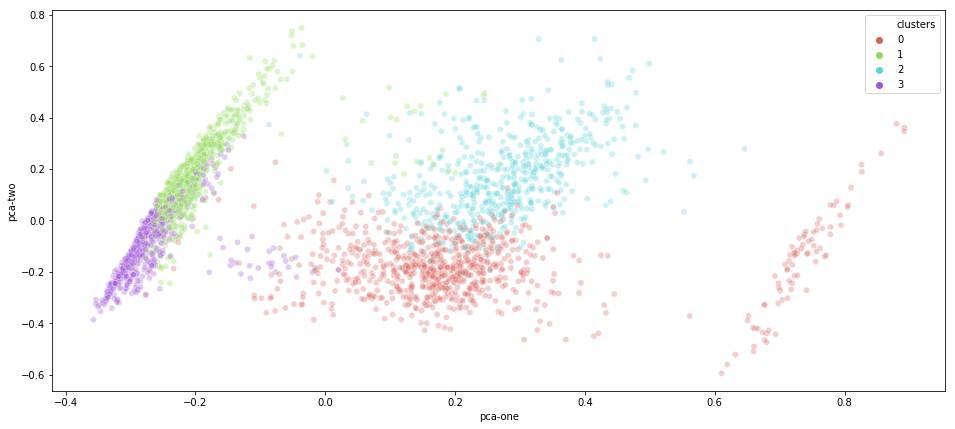

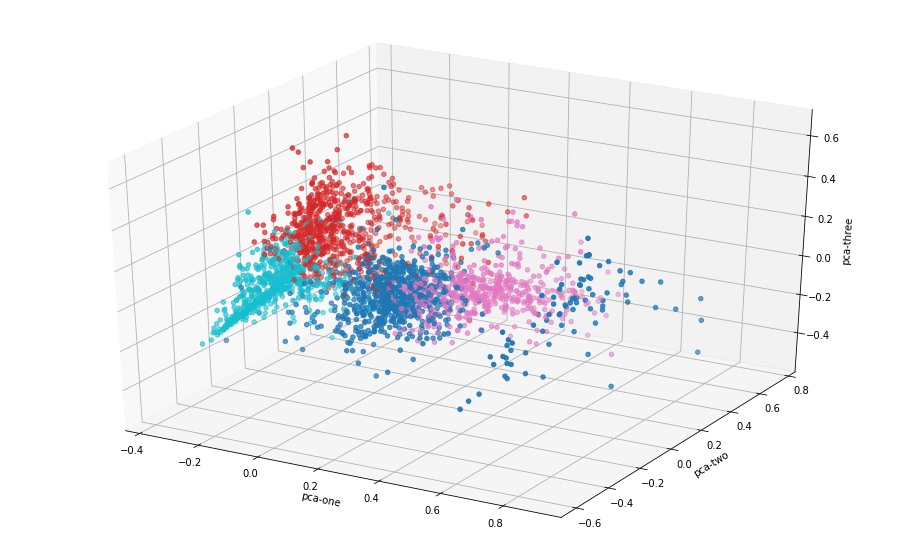

In [8]:
# Performing t-sne on data
time_start = time.time()       #init time 
tsne = TSNE(n_components=2, verbose=1, perplexity= 70, n_iter=700, random_state = 2) ## Chose params through iterative testing
tsne_results = tsne.fit_transform(df_scaled)
print('Time elapsed: {} seconds'.format(time.time()-time_start))
df_scaled.head()

# Performing PCA on data
pca = PCA(n_components=3)
pca_result = pca.fit_transform(df_scaled)
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))


# Merging t-sne and pca results in sclaed dataframe
df_scaled['tsne-2d-one'] = tsne_results[:,0]
df_scaled['tsne-2d-two'] = tsne_results[:,1]
df_scaled['pca-one'] = pca_result[:,0]
df_scaled['pca-two'] = pca_result[:,1] 
df_scaled['pca-three'] = pca_result[:,2]
df_scaled['clusters'] = clustering.labels_

## Visualizing clusters in a 2-D Space using tsne
plt.figure(figsize=(10,5))
sns.scatterplot(
x = df_scaled["tsne-2d-one"], 
y = df_scaled["tsne-2d-two"],
hue = df_scaled['clusters'],
palette=sns.color_palette("hls",  4),
legend="full",
alpha=0.3)
plt.show()


## Visualizing Clusters in a 2-D & 3-D Space using PCA
plt.figure(figsize=(16,7))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue = 'clusters',
    data=df_scaled,
    palette=sns.color_palette("hls",  4),
    legend="full",
    alpha=0.3)


ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.scatter(
    xs=df_scaled["pca-one"], 
    ys=df_scaled["pca-two"], 
    zs=df_scaled["pca-three"], 
    c=df_scaled['clusters'], 
    cmap='tab10'
)
ax.set_xlabel('pca-one')
ax.set_ylabel('pca-two')
ax.set_zlabel('pca-three')
plt.show()

,pim_gp,even_g_gp,pp_g_gp,sh_g_gp,gw_g_gp,even_a_gp,pp_a_gp,sh_a_gp,sh_perc,avg_blocks,avg_hits,fow
cluster,,,,,,,,,,,,
0.0,0.641938,0.112468,0.006931,0.003687,0.016181,0.112468,0.013646,0.003057,0.100136,0.408333,1.186499,0.491362
1.0,0.615761,0.138536,0.017975,0.002034,0.010810,0.138536,0.060111,0.005981,0.059574,0.845100,0.902394,0.009248
2.0,0.497053,0.223103,0.064208,0.005425,0.034575,0.223103,0.099243,0.004307,0.125991,0.402286,0.706489,0.447702
3.0,0.763384,0.090861,0.005982,0.000819,0.003956,0.090861,0.007408,0.001533,0.047298,0.160016,0.420004,0.007128


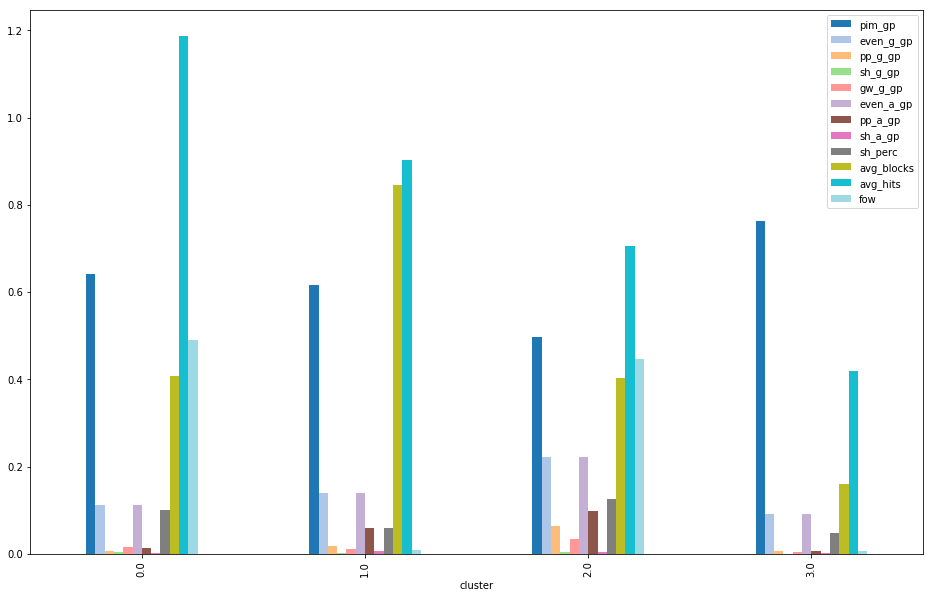

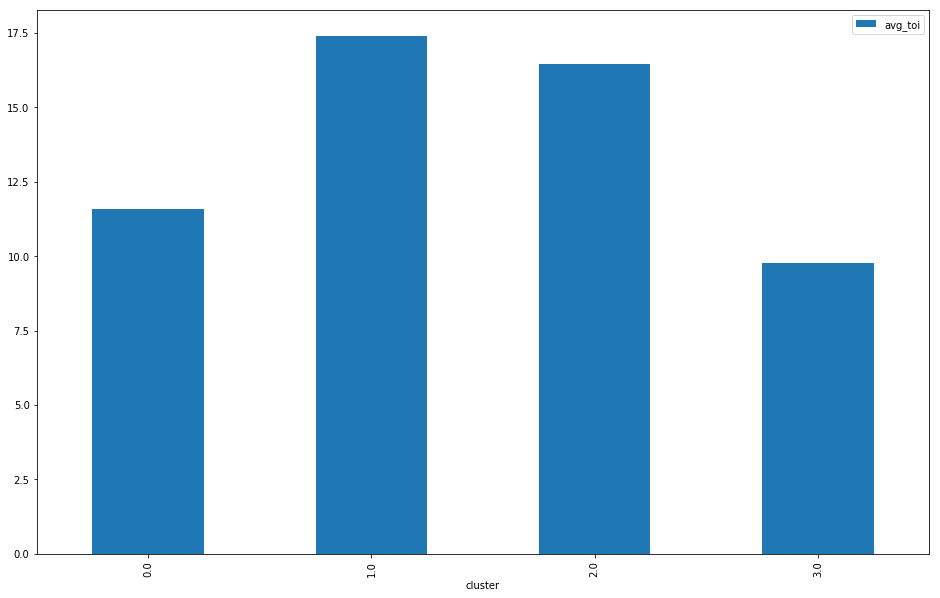

In [9]:
## Understanding the clusters

stats_df = pd.DataFrame(columns = stat_columns)
for i in range(0,4):
    stats = inversed.loc[inversed['cluster'] == i].describe()
    mean = stats.iloc[1]
    stats_df = stats_df.append(mean)

stats_df = stats_df.set_index('cluster')

stats_df_only_toi = stats_df[['avg_toi']]
stats_df_no_toi = stats_df.drop('avg_toi', axis = 1) ## Seperating because values are large

stats_df_no_toi.plot(kind = 'bar', figsize =  (16,10), colormap = 'tab20')
stats_df_only_toi.plot(kind = 'bar', figsize =  (16,10))

stats_df_no_toi